In [1]:
import pandas as pd
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split
import keras
from keras import Model, Input
from keras.layers import Conv1D, Flatten, Dense, Dropout, SpatialDropout1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, roc_auc_score
from keras.callbacks import TensorBoard, ModelCheckpoint
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)


Num GPUs Available:  1


In [3]:
metadata = pd.read_csv('/content/drive/MyDrive/archive (17)/bird_songs_metadata.csv')
metadata.head()

,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [4]:
# Lists for storing the filepaths and labels
file_paths = []
labels = []

audio_dir = '/content/drive/MyDrive/archive (17)/wavfiles/'

for index, row in metadata.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    if os.path.exists(file_path):
        file_paths.append(file_path)
        labels.append(row['species'])

file_paths[:5], labels[:5]

(['/content/drive/MyDrive/archive (17)/wavfiles/557838-0.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-1.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-4.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-5.wav',
  '/content/drive/MyDrive/archive (17)/wavfiles/557838-6.wav'],
 ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii'])

In [5]:
# Converting labels to numeric
label_dict = {label: index for index, label in enumerate(set(labels))}
y = np.array([label_dict[label] for label in labels])
y[:5]

array([3, 3, 3, 3, 3])

In [6]:
def read_file(path):
    y,_ = librosa.load(path)
    return y

def spec_to_db(y):
    y_db = librosa.amplitude_to_db(y, ref=100)
    return y_db

def map_function(path_tensor, label):
    y=tf.numpy_function(read_file, inp= [path_tensor], Tout = tf.float32)
    spectrogram = tf.abs(tf.signal.stft(y, frame_length=512, frame_step=64))
    spectrogram_db = tf.numpy_function(spec_to_db, inp = [spectrogram], Tout = tf.float32)
    spectrogram_db = spectrogram_db/80+1
    return spectrogram_db, label

def make_dataset(labels, file_paths, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=dataset.cardinality(), reshuffle_each_iteration=True)
    dataset = dataset.map(map_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=64, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

In [7]:
file_paths_train, file_paths_test, y_train, y_test = train_test_split(
    file_paths, y, test_size=0.10, random_state=2419)

dataset_train = make_dataset(y_train, file_paths_train, shuffle=True)
dataset_test = make_dataset(y_test, file_paths_test, shuffle=False)

In [8]:
def create_model():
    inputs = Input((1026, 257), name = '0_Input_shape')

    x = Conv1D(128,8,2, activation='relu', padding='same', name = '1_Conv1D')(inputs)
    x = SpatialDropout1D(0.17, name = '2_SpatialDropout1D')(x)

    x = Conv1D(128,8,2, activation='relu', padding='same', name = '3_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '4_SpatialDropout1D')(x)

    x = Conv1D(128,8,2, activation='relu', padding='same', name = '5_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '6_SpatialDropout1D')(x)

    x = Conv1D(128,8,2, activation='relu', padding='same', name = '7_Conv1d')(x)
    x = SpatialDropout1D(0.17, name = '8_SpatialDropout1D')(x)

    x = GlobalAveragePooling1D(name = '9_Global_avg_pooling')(x)
    x = Dense(512, activation='relu', name='10_Dense')(x)
    x = Dropout(0.5, name='11_Dropout')(x)
    outputs = Dense(5, name='12_Dense')(x)
    model = Model(inputs=inputs, outputs=outputs, name = 'Bird_audio_classification_model')

    return model

In [9]:
model = create_model()
model.summary()

Model: "Bird_audio_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_Input_shape (InputLayer)  [(None, 1026, 257)]       0         
                                                                 
 1_Conv1D (Conv1D)           (None, 513, 128)          263296    
                                                                 
 2_SpatialDropout1D (Spatia  (None, 513, 128)          0         
 lDropout1D)                                                     
                                                                 
 3_Conv1d (Conv1D)           (None, 257, 128)          131200    
                                                                 
 4_SpatialDropout1D (Spatia  (None, 257, 128)          0         
 lDropout1D)                                                     
                                                                 
 5_Conv1d (Conv1D)           (None,

In [10]:
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3,
                               decay_steps= 4000, decay_rate = 0.5, staircase=False, name=None)

model.compile(optimizer = Adam(lr_schedule),
              loss = SparseCategoricalCrossentropy(from_logits = True),
              metrics = [ SparseCategoricalAccuracy()])

In [11]:
# Creating callbacks
logdir = 'tb_logs/model'
tensorboard_callback = TensorBoard(log_dir=logdir)

checkpoint_filepath = 'model_checkpoint/model'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
training = model.fit(dataset_train, validation_data = dataset_test, epochs=120,
                    callbacks=[tensorboard_callback,model_checkpoint_callback])


Epoch 1/120
76/76 [==============================] - ETA: 0s - loss: 1.4272 - sparse_categorical_accuracy: 0.3283

76/76 [==============================] - 317s 4s/step - loss: 1.4272 - sparse_categorical_accuracy: 0.3283 - val_loss: 1.2370 - val_sparse_categorical_accuracy: 0.3945
Epoch 2/120
76/76 [==============================] - ETA: 0s - loss: 1.2488 - sparse_categorical_accuracy: 0.4208

76/76 [==============================] - 19s 246ms/step - loss: 1.2488 - sparse_categorical_accuracy: 0.4208 - val_loss: 1.1048 - val_sparse_categorical_accuracy: 0.4785
Epoch 3/120
76/76 [==============================] - 19s 246ms/step - loss: 1.1684 - sparse_categorical_accuracy: 0.4739 - val_loss: 1.0550 - val_sparse_categorical_accuracy: 0.5352
Epoch 4/120
76/76 [==============================] - 18s 243ms/step - loss: 1.0801 - sparse_categorical_accuracy: 0.5144 - val_loss: 0.9801 - val_sparse_categorical_accuracy: 0.6074
Epoch 5/120
76/76 [==============================] - 17s 227ms/step - loss: 1.0215 - sparse_categorical_accuracy: 0.5508 - val_loss: 0.9787 - val_sparse_categorical_accuracy: 0.5977
Epoch 6/120
76/76 [==============================] - 18s 234ms/step - loss: 0.9551 - sparse_categorical_accuracy: 0.5866 - val_loss: 0.8754 - val_sparse_categorical_accuracy: 0.6191
Epoch 7/120
76/76 [==============================] - 18s 232ms/step - loss: 0.9259 - sparse_categorica

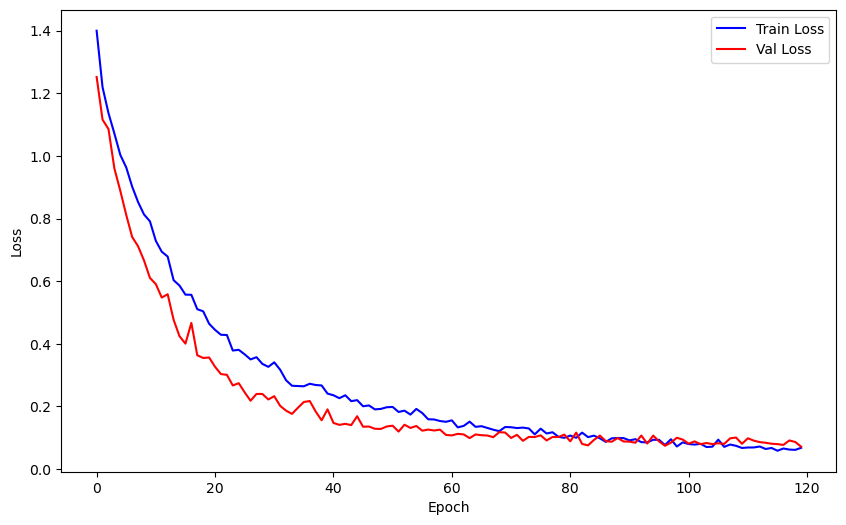

In [ ]:
train_loss_df = pd.read_csv("/Users/adi/Downloads/bird_sound_models/Model_1/train_loss.csv")
val_loss_df = pd.read_csv("/Users/adi/Downloads/bird_sound_models/Model_1/val_loss.csv")

plt.figure(figsize=(10, 6))
plt.plot(train_loss_df['Step'], train_loss_df['Value'], label='Train Loss', color='blue')
plt.plot(val_loss_df['Step'], val_loss_df['Value'], label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
y_logits = model.predict(dataset_test)
y_prob = tf.nn.softmax(y_logits, axis=1)
y_pred = tf.argmax(y_logits, axis=1)
y_true = tf.concat(list(dataset_test.map(lambda s,lab: lab)), axis=0)

8/8 [==============================] - 2s 206ms/step


In [14]:
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_prob, average='macro', multi_class='ovo')
print(f"F1: {f1} | Precision: {precision} | Recall: {recall} | AUC: {auc}")

F1: 0.9747716801422964 | Precision: 0.9738192228200395 | Recall: 0.9759864979289814 | AUC: 0.9990287517747255


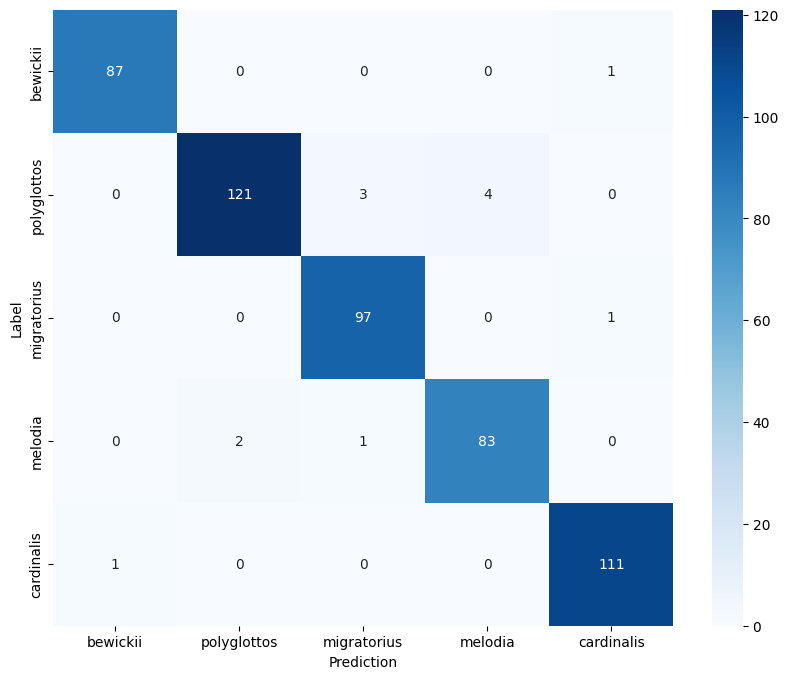

In [15]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            yticklabels=['bewickii','polyglottos','migratorius','melodia','cardinalis'],
            annot=True, fmt='g', cmap = 'Blues')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()